In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve

In [3]:
# Get the data. No need for a data frame since it's image data
mnist = fetch_openml("mnist_784", as_frame=False)

/Users/adamscarlat/miniconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


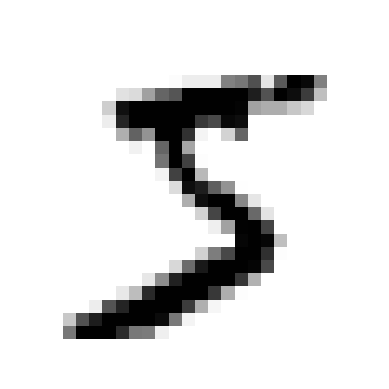

5


In [10]:
# Get data and labels
X, y = mnist.data, mnist.target

# Each instance is an flattened 28x28 = 784 pixel image 
# Each label is a number 0-9
print (X.shape)
print (y.shape)

# Seeing one image as an example
def plot_digit(image_data):
  image = image_data.reshape(28,28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()
print (y[0])



In [11]:
# The MNIST dataset is already shuffled and split into train and test datasets. The first 60K images are for 
# training.

# With classification models, it's important that our training set contains an example of each digit. If we were to shuffle
# and split the data ourselves, we would have had to use stratified split with the labels as the stratification parameter.

# In addition to have an example of every image in our training set, the order they appear can affect the training as well.
# Shuffling them to a random order is important.

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Training a Binary Classifier

In [24]:
# To start, let's build a simple classifier that can identify 5 or no 5

# This will change the labels to True when the label is 5, False otherwise
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [25]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [28]:
# Our random 'some_digit' variable (which we know is 5)
sgd_clf.predict([some_digit])

array([ True])

### Measuring Performance

In [30]:
# Using k-fold cross validation to test our 5-only binary classifier

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [33]:
# We can see high accuracy for the binary 5-only classifier. Does it mean it's a good classifier? Accuracy is not enough. 
# This classifier could have missed many 5's (said no instead of yes), i.e it could have a high number of false negatives.
# Accuracy only tells us the percentage of correct answers (yes or no) out of all answers. High accuracy for a model
# means - when the model gave an answer (yes or no), it was most likely the right answer.

# To see how accuracy is not enough, we can create a dummy classifier which always classifies the most frequent class. In
# our case, the false class. This helps us to establish a baseline
dummy_clf = DummyClassifier()
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# We can see that the dummy model got over 90% accuracy. That's because the number 5 is 10% of the dataset... if you guess
# that an image is not a 5, you'll be correct 90% of the time.


array([0.90965, 0.90965, 0.90965])

In [35]:
# Accuracy is not great performance metric for classifiers and especially not a good one for skewed datasets where there
# is a class imbalance. A better performance metric (or metrics) is the confusion matrix. 

# cross_val_predict returns the actual predictions made in each fold instead of a score. It'll take the most frequent
# prediction out of the k models predictions in the result (you'll get back a single array)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [40]:
# Generate a confusion matrix. It takes the real labels and the predicted labels and returns a matrix:
#
#    | neg` pos`
# neg: TN,  FP 
# pos: FN,  TP 
#
# Notice that each row represents the entire elements of a class. Each column represents predicted elements of a certain class.

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Using the confusion matrix's values we can start computing more insightful metrics:

* Precision: TP / (TP + FP)
  - From all the times the classifier predicted YES, how many of those were correct.
  - Ratio of correct YES to ALL PREDICTED YES 
  - Example, training a model that makes sure a video is safe for kids (YES means safe for kids). You'd care more
    about the precision since it's better to be wrong and censor a video than letting a kid see an unsafe video.
    Here lower recall would mean that the algorithm decided that some safe videos are actually unsafe which is ok.
* Recall: TP / (TP + FN)
  - Given the model's TP count, what's its percentage considering all positives
  - Ratio of correct YES to ALL ACTUAL YES
  - Example, training a model that detects shoplifting (YES means shoplifter). Here high recall would be preferable since
    you don't want to miss shoplifter. Lower precision would mean that the store checks people that aren't shoplifter, 
    which isn't great but not as bad as having stuff stolen.
* F1: 2 * (precision * recall) / (precision + recall)
  - The harmonic mean of precision and recall. Harmonic mean gives more weight to lower values. If precision is high
    and recall is low, the F1 score will get dragged more to the lower end.
  - F1 favors classifiers that have similar precision and recall. 

The precision/recall tradeoff: Increasing precision reduces recall and vice versa.
  * The reason is because models that classify compute a probability that an instance belongs to a class 
    and then use a threshold on that probability to make a decision.
  * Reducing this threshold would make the model say YES more easily, hence increasing the recall (it throws a wider
    net, catching more stuff but also junk - FPs).
  * Increasing this threshold would make the model say NO more easily, hence increasing the precision (it throws a
    small, more targeted net, catching less things - more FNs - but the stuff it does catch are more likely
    tp be true).


In [48]:
# Precision is 83% - meaning, when it says YES, it's correct 83% of the time
print ("Precision:", precision_score(y_train_5, y_train_pred))

# Recall is 65% - meaning all the YES it said covered 65% of the actual YES examples
print ("Recall:", recall_score(y_train_5, y_train_pred))

print ("F1: ", f1_score(y_train_5, y_train_pred))

Precision: 0.8370879772350012
Recall: 0.6511713705958311
F1:  0.7325171197343846


In [56]:
# The precision / recall tradeoff

# The SGD classifier does not let you change the threshold, instead it lets you get the confidence for each prediction
# and you can combine it with a threshold to make decisions

y_scores = sgd_clf.decision_function(X_train)
threshold = 3000
y_pred_after_threshold = (y_scores >= threshold)
print ("Precision threshold 3000:", precision_score(y_train_5, y_pred_after_threshold))
print ("Recall threshold 3000:", recall_score(y_train_5, y_pred_after_threshold))

threshold = 6000
y_pred_after_threshold = (y_scores >= threshold)
print ("Precision threshold 6000:", precision_score(y_train_5, y_pred_after_threshold))
print ("Recall threshold 6000:", recall_score(y_train_5, y_pred_after_threshold))

# This shows how increasing the prediction threshold increases precision and reduces recall. 
# Think of it as the inverse to the size of the net thrown - higher threshold, smaller net and vice versa

Precision threshold 3000: 0.9390070921985816
Recall threshold 3000: 0.610588452315071
Precision threshold 6000: 0.9829619921363041
Recall threshold 6000: 0.27670171555063644


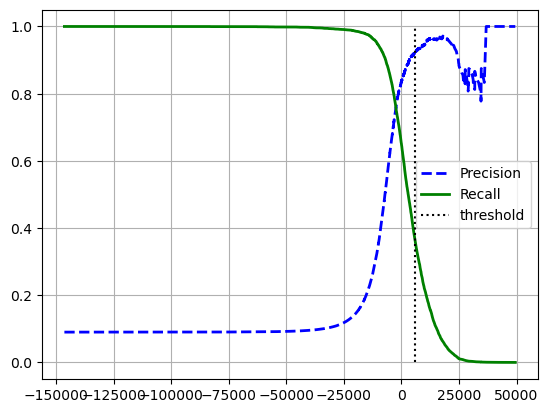

In [64]:
# How do we know which threshold to use?

# We want to find the threshold that fits our problem's needs (see recall and precision examples).

# We can use the classifier's decision_function as a metric for the cross val function. This will return the aggregated
# scores from all k folds
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# The we can get a precision recall curve and plot it
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.legend()
plt.grid()
plt.show()

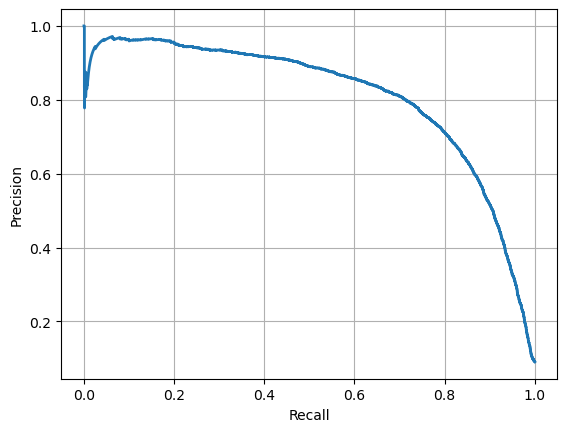

In [63]:
# Another way to plot it is to have the precision as a function of the recall
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()


In [114]:
# Now that you saw the curve and you're ready to get the right threshold for your project, you do the following (getting
# it from the curve is not accurate):

# Assume that you want to find the threshold that'll keep precision at 90%
# The precisions and recalls array are sorted in ascending order. This means that if we find the first threshold over 90%
# precision, we can use it

# Get the index of the first precision over 90%
precision_wanted = 0.9

# get array of true when the value is over 0.9, false otherwise
precisions_over_val = (precisions >= precision_wanted)

# get the index of the first max value (index of the first True)
precision_over_val_idx = np.argmax(precisions_over_val >= precision_wanted)

# get the threshold at that index
threshold_precision_val = thresholds[precision_over_val_idx]

# now to get a prediction, instead of calling predict on the classifier, we call the decision_function and use our threshold
digits_to_predict = X_train[40:50]
digits_to_predict_scores = sgd_clf.decision_function(digits_to_predict)
predictions = (digits_to_predict_scores >= threshold_precision_val)
actuals = y_train[40:50]

df = pd.DataFrame([[predictions.astype(int), actuals]])
df.T


,0
0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
1,"[1, 8, 7, 9, 3, 9, 8, 5, 9, 3]"


### The ROC Curve